#Preparing the environment

In [1]:
!pip install opencv-python
!pip install pytesseract==0.3.9
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [2]:
!git clone https://github.com/sthemonica/text-recognize

fatal: destination path 'text-recognize' already exists and is not an empty directory.


In [3]:
!tesseract --list-langs

List of available languages (3):
eng
osd
por


In [4]:
!apt-get install tesseract-ocr-por

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-por is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [5]:
config_tesseract='--tessdata-dir /usr/share/tesseract-ocr/4.00/tessdata --psm 11'


#Developing the code

In [6]:
import re
import os
import cv2
import numpy as np
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw,ImageFont
from google.colab.patches import cv2_imshow

In [7]:
!git clone 'https://github.com/kavin808/arial.ttf.git' #collecting archives
projeto='/content/text-recognize/Imagens/Projeto' #images adress
arquivo_fonte='/content/arial.ttf/arial.ttf' #font to impression

fatal: destination path 'arial.ttf' already exists and is not an empty directory.


In [8]:
termo_pesquisa='learning' #the term which we're looking for
padrao_pesquisa= rf'\b.*{termo_pesquisa}.*\b' #a regular expression representing the term and his variantions

In [9]:
caminho=[os.path.join(projeto,nome_arquivo) for nome_arquivo in os.listdir(projeto)] #making a list called 'caminho' with the images adress to 'projeto' (concatenating then)

In [10]:
def resultados(img): #identify the terms from archives
  resultados=pytesseract.image_to_data(img,lang='por',
                                        config=config_tesseract,
                                        output_type=Output.DICT)
  return resultados
def imagem_rgb(img): #converts to rgb color channel (not used here)
  rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  return rgb

def imprime_texto(img): #return a string of the terms writen in a specifically image
  texto=pytesseract.image_to_string(img,lang='por',config=config_tesseract)
  return texto

def caixa_delimitadora(img,i,resultados,cor): #create the text delimiter box
  x=resultados['left'][i]
  y=resultados['top'][i]
  w=resultados['width'][i]
  h=resultados['height'][i]
  cv2.rectangle(img,(x,y),(x+w,y+h),cor)
  return img,x,y

def escreve_texto(texto, x, y, img, fonte_dir,cor, tamanho=11): #writes the text on the image using Arial font
  fonte = ImageFont.truetype(fonte_dir, tamanho)
  img_pil = Image.fromarray(img)
  draw = ImageDraw.Draw(img_pil)
  draw.text((x, y-13), texto, font = fonte,fill=cor)
  img = np.array(img_pil)
  return img

#mostra_palavra is an alternative function for writing the text on the image.
#It's not useful as the other (mainly in portuguese) due to OCR doesn't
#recognize certain special characters.

#def mostra_palavra(img,texto,x,y,cor):
#  cv2.putText(img,texto,(x,y-2),cv2.FONT_HERSHEY_SIMPLEX,fontScale=0.4,color=cor)
#  return img

def transcreva_txt_colab(guarda_transcricao,nome_txt,i=0): #transcrips and treats the text of all images to create a txt document. It prints the text in the final.
  texto_completo=''
  arquivo_txt=open(nome_txt,'w+')
  while i<len(guarda_transcricao):
    texto_extraido=guarda_transcricao[i]
    transcricao_imagem=texto_extraido.replace('\n\n',' ')
    transcricao_imagem=transcricao_imagem.replace('\n\x0c','')
    arquivo_txt.write(transcricao_imagem +'\n')
    i+=1
    print(transcricao_imagem)
  nome_txt=formata_transcricao_p_txt(nome_txt)
  arquivo_txt.close()


def formata_transcricao_p_txt(nome_txt): #treats the txt document, deleting gaps
  with open(nome_txt, 'r') as entrada_c_gaps:
    linhas = entrada_c_gaps.readlines()

  with open(nome_txt, 'w') as saida_s_gaps:
      for linha in linhas:
          if linha.strip():
              saida_s_gaps.write(linha)
  return nome_txt

def imprime_correspondencias(caminho): #extracts the name of each image. After that,
#'numero_correspondencias' catch ups their indexes and give the leght of them. Finally,
#it's printed as the number of aparisions of any term
  for imagem in caminho:
    nome_imagem=os.path.split(imagem)[-1]
    img=cv2.imread(imagem)
    string=pytesseract.image_to_string(img)
    numero_correspondencias=len([i.start() for i in re.finditer(r'\b.*learning.*\b',string,re.IGNORECASE)])
    print(f'Correspondências ao termo "{termo_pesquisa}" em {nome_imagem}: {numero_correspondencias}')
    print('====================================================================== \n')


In [11]:
min_conf = 19#@param{type:'slider',min:0,max:100}
#is used to define a mininum value of confiability to filter what's on the text key of pytesseract.image_to_data()

Processando 1a imagem...


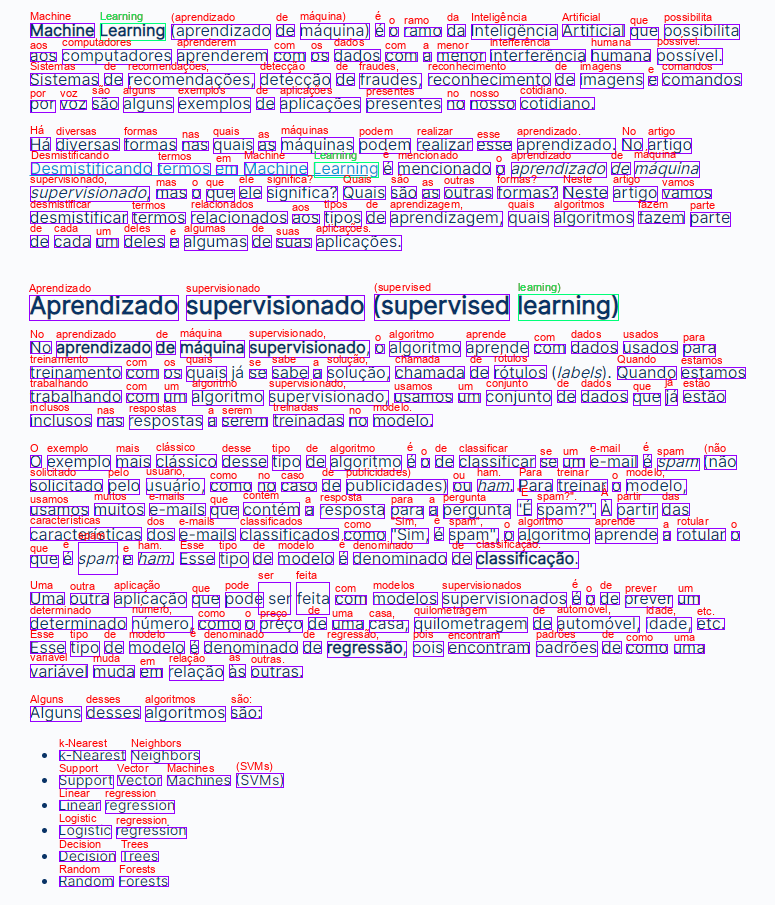

Processando 2a imagem...


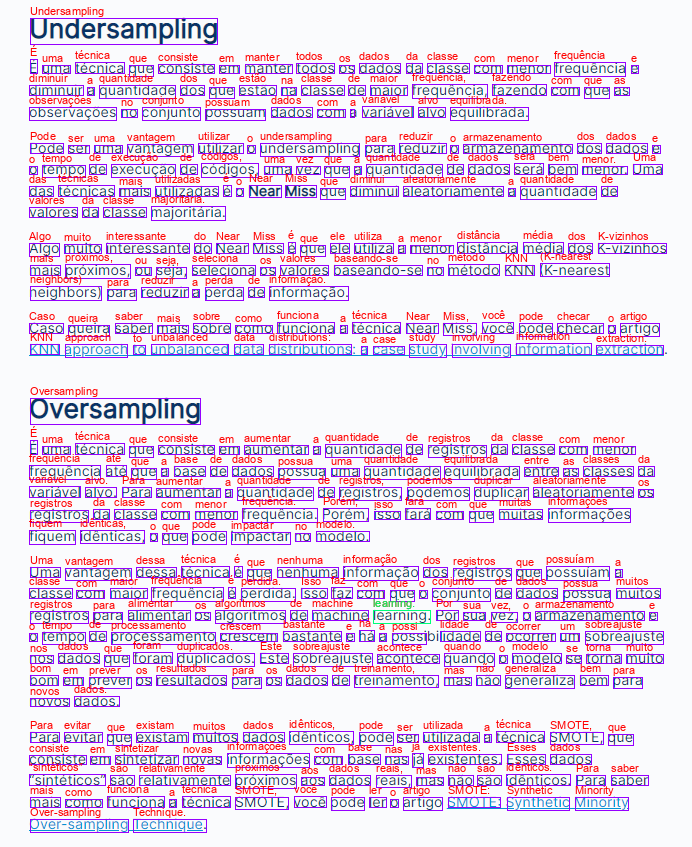

Processando 3a imagem...


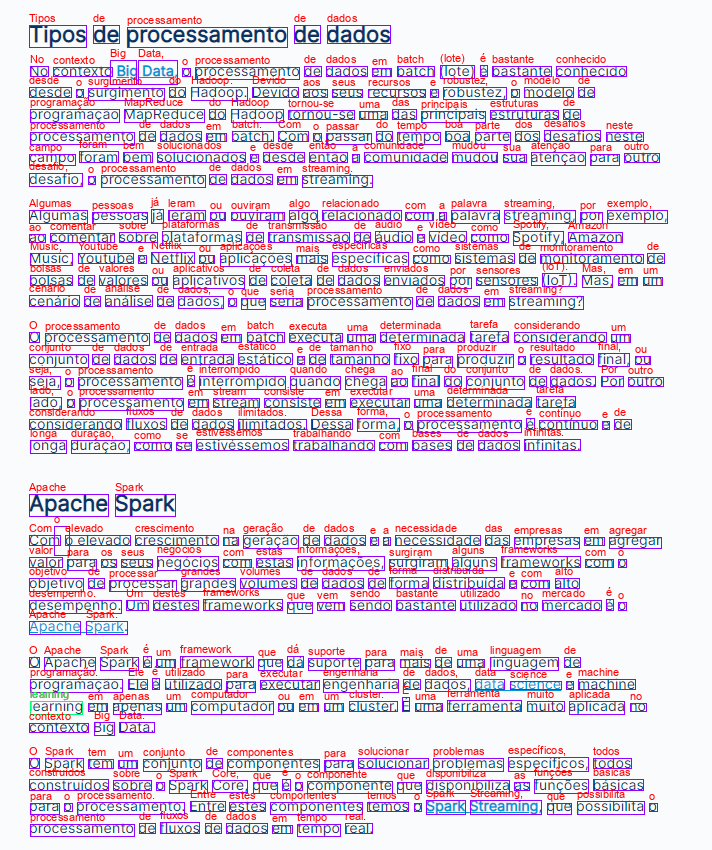

Processando 4a imagem...


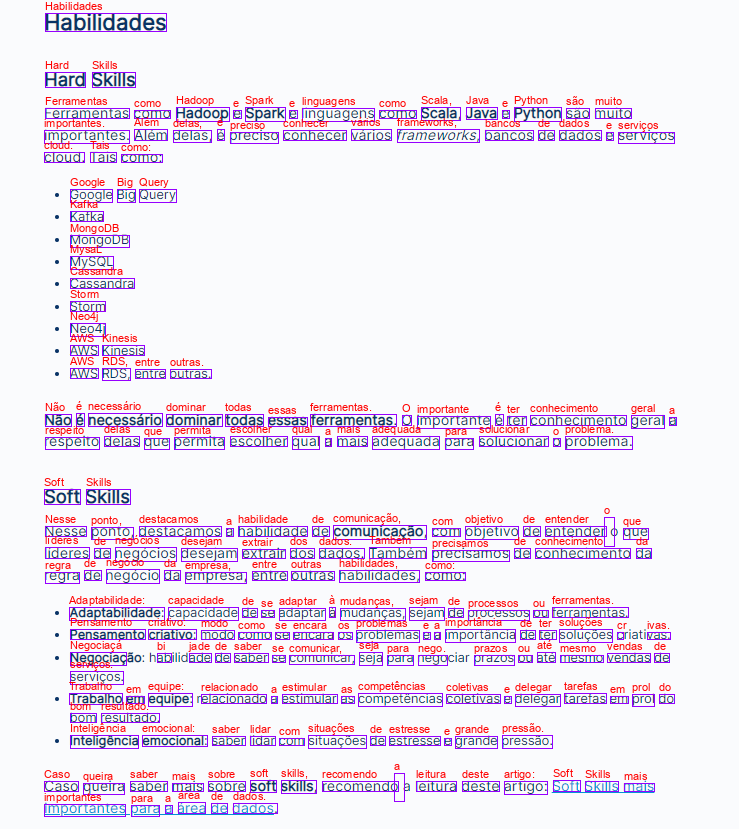

Fim do processamento


In [12]:
guarda_transcricao=[] #to save results of resultados['text']
for index,imagem in enumerate(caminho,start=1): #for each word indentified (including the searched word in a different color),
#saves the transcription in 'guarda_transcricao',
#compars her confiability to min_conf and re,
#draw the text limiters, the transcription and save every made images in 'resultados'

  img=cv2.imread(imagem)
  rgb=imagem_rgb(img)
  transcricao=imprime_texto(img)
  guarda_transcricao.append(transcricao)
  print(f'Processando {index}a imagem...')
  resultados=pytesseract.image_to_data(img,lang='por',
                                      config=config_tesseract,
                                      output_type=Output.DICT)

  for i in range (len(resultados['text'])):
    confianca=int(resultados['conf'][i])
    texto=resultados['text'][i]

    if confianca>min_conf:
      caixa_delimitada,x,y=caixa_delimitadora(img,i,resultados,(255,0,150))
      img=escreve_texto(texto, x, y, img, arquivo_fonte,(0,0,255))


    if re.match(padrao_pesquisa,texto,re.IGNORECASE):
       caixa_delimitada,x,y=caixa_delimitadora(img,i,resultados,(120,255,0))

       img=escreve_texto(texto, x, y, img, arquivo_fonte,(100,255,0))

  os.makedirs('resultados_localizacao', exist_ok=True)
  imagem_final=f'/content/resultados_localizacao/imagem_final{index}.png'
  cv2.imwrite(imagem_final,img)

  cv2_imshow(img)
print('Fim do processamento')


#Applicating

In [13]:
transcricao_formatada_p_colab=transcreva_txt_colab(guarda_transcricao,nome_txt='resultados_ocr.txt') #comes with a transcription of detected
#texts and put it on the resultados_ocr.txt
transcricao_formatada_p_colab

Machine Learning (aprendizado de máquina) é o ramo da Inteligência Artificial que possibilita aos computadores aprenderem com os dados com a menor interferência humana possível. Sistemas de recomendações, detecção de fraudes, reconhecimento de imagens e comandos por voz são alguns exemplos de aplicações presentes no nosso cotidiano. Há diversas formas nas quais as máquinas podem realizar esse aprendizado. No artigo Desmistificando termos em Machine Learning é mencionado o aprendizado de máquina supervisionado, mas o que ele significa? Quais são as outras formas? Neste artigo vamos desmistificar termos relacionados aos tipos de aprendizagem, quais algoritmos fazem parte de cada um deles e algumas de suas aplicações. Aprendizado supervisionado (supervised learning) No aprendizado de máquina supervisionado, o algoritmo aprende com dados usados para E treinamento com os quais se sabe a solução, chamada de rótulos (labels). Quando estamos trabalhando com um algoritmo supervisionado, usamos 

In [14]:
imprime_correspondencias(caminho) #quantifies of the searched term in each image

Correspondências ao termo "learning" em artigo-termos-ML.png: 3

Correspondências ao termo "learning" em artigo-desbalanceamento.png: 1

Correspondências ao termo "learning" em artigo-spark.png: 1

Correspondências ao termo "learning" em artigo-eng-dados.png: 0

